In [1]:
!pip install mmh3 -qq
!pip install transformers -qq
!pip install sentence-transformers -qq
!pip install ipython-autotime -qq
%load_ext autotime

time: 690 µs (started: 2023-12-14 21:08:42 +00:00)


In [2]:
import random
from sklearn.utils import murmurhash3_32
import math
import csv
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import heapq
import matplotlib.pyplot as plt
import numpy as np




time: 1.05 s (started: 2023-12-14 21:08:42 +00:00)


In [3]:
def preproc(text, ngram =3):
    ngram_list = [text[i:i+ngram] for i in range(len(text)-(ngram-1))]
    return ngram_list

def hash_factory(seed_val):
    return lambda x: murmurhash3_32(x, seed = seed_val)

def MinHash(text, seed=512, m=100):
    random.seed(seed)
    seed_list = random.sample(range(10*m),m)
    hashes = [hash_factory(seed_list[i]) for i in range(m)]
    return [min([hash(x) for x in text]) for hash in hashes]

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

time: 1.34 ms (started: 2023-12-14 21:08:43 +00:00)


In [4]:
class HashTable ():
    def __init__ (self , k, l, b, r):
        self.k = k
        self.l = l
        self.b = b
        self.r = r
        self.hashtables = [{} for idx in range(self.l)]

    def insert (self , hashcodes , id):
        for num10 in range(self.l):
            codes = tuple(hashcodes[(num10*self.k):(num10*self.k)+self.k])
            if codes not in self.hashtables[num10]:
                self.hashtables[num10][codes] = []
            if len(self.hashtables[num10][codes]) < self.b:
                self.hashtables[num10][codes].append(id)
          #print(codes,self.hashtables[idx][codes])
        return

    def lookup (self , hashcodes):
        ids = set()
        for idx in range(self.l):
            codes = tuple(hashcodes[(idx*self.k):(idx*self.k)+self.k])
            if codes in self.hashtables[idx]:
                ids.update(self.hashtables[idx][codes])
        return ids



time: 2.68 ms (started: 2023-12-14 21:08:43 +00:00)


In [5]:
data = pd.read_csv("/kaggle/input/amazon-product-dataset-2020/home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv")
print("Total Number of rows for raw data", data.shape[0])
data['Selling Price'] = data['Selling Price'].fillna('')
condition = ~data['Selling Price'].str.contains('[a-zA-Z]') & (data['Selling Price'].str.count('\$') <= 1)
clear_data = data[condition].copy()
clear_data['Selling Price'] = pd.to_numeric(clear_data['Selling Price'].str.replace(',', '').str.replace('$', ''), errors='coerce')

#clear_data['Selling Price'] = clear_data['Selling Price'].str.replace(',', '').str.replace('$', '').astype(float)
clear_data = clear_data.dropna(subset=['Product Name', 'Category','Selling Price'])[['Product Name', 'Category','Selling Price']].reset_index(drop=True)
print("Total Number of rows after clearning empty cells", clear_data.shape[0])
tot_len = clear_data.shape[0]

Total Number of rows for raw data 10002
Total Number of rows after clearning empty cells 8716
time: 667 ms (started: 2023-12-14 21:08:43 +00:00)


In [6]:
clear_data = clear_data.rename_axis('ID')
clear_data.head(10)

,Product Name,Category,Selling Price
ID,,,
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Sports & Outdoors | Outdoor Recreation | Skate...,237.68
1,"Electronic Snap Circuits Mini Kits Classpack, ...",Toys & Games | Learning & Education | Science ...,99.95
2,3Doodler Create Flexy 3D Printing Filament Ref...,Toys & Games | Arts & Crafts | Craft Kits,34.99
3,Guillow Airplane Design Studio with Travel Cas...,Toys & Games | Hobbies | Models & Model Kits |...,28.91
4,Woodstock- Collage 500 pc Puzzle,Toys & Games | Puzzles | Jigsaw Puzzles,17.49
5,Rubie's Child's Pokemon Deluxe Pikachu Costume...,"Clothing, Shoes & Jewelry | Costumes & Accesso...",29.12
6,Hoffmaster 120813 Double-Tipped Triangular Cra...,Toys & Games | Arts & Crafts | Drawing & Paint...,97.68
7,"ARTSCAPE Etched Glass 24"" x 36"" Window Film, 2...",Home & Kitchen | Home Décor | Window Treatment...,12.99
8,"Moonlite, 3-Story Bundle for Boys, Includes 3 ...",Toys & Games | Baby & Toddler Toys,18.16


time: 19 ms (started: 2023-12-14 21:08:44 +00:00)


In [7]:
pname_text = [preproc(clear_data["Product Name"].iloc[idx], ngram =3) for idx in tqdm(range(tot_len))]
cat_text = [preproc(clear_data["Category"].iloc[idx], ngram =3) for idx in tqdm(range(tot_len))]


pname_ngrams_list = []
for idx in tqdm(range(tot_len)):
  pname_ngrams_list.append(MinHash(text = pname_text[idx], m =100))

cat_ngrams_list = []
for idx in tqdm(range(tot_len)):
  cat_ngrams_list.append(MinHash(text = cat_text[idx], m =100))



100%|██████████| 8716/8716 [00:30<00:00, 286.33it/s]

time: 1min 2s (started: 2023-12-14 21:08:44 +00:00)


In [8]:
clear_data = clear_data.reset_index()
train_data, val_data = train_test_split(clear_data, test_size=0.1, random_state=42)

time: 8.94 ms (started: 2023-12-14 21:09:46 +00:00)


In [9]:
train_data.head(10)
train_data.shape

(7844, 4)

time: 4.61 ms (started: 2023-12-14 21:09:46 +00:00)


In [10]:
l = 50
k = 2
hashtable1 = HashTable(k=2, l=50, b=64, r = pow(2,20))
for idx in range(train_data.shape[0]):
    num = train_data["ID"].iloc[idx]
    pname_ngrams = pname_ngrams_list[num][:k*l]
    hashtable1.insert(hashcodes = pname_ngrams, id = num)

hashtable2 = HashTable(k=2, l=50, b=64, r = pow(2,20))
for idx in range(train_data.shape[0]):
    num = train_data["ID"].iloc[idx]
    cat_ngrams = cat_ngrams_list[num][:k*l]
    hashtable2.insert(hashcodes = cat_ngrams, id = num)

time: 2.04 s (started: 2023-12-14 21:09:46 +00:00)


In [ ]:
cum_jac = 0
counter = 0
top_sim = 0
len_top10 = 0
variance_list = []
for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    pname_ids = hashtable1.lookup(pname_ngrams_list[num])
    cat_ids = hashtable2.lookup(cat_ngrams_list[num])
    sim_dict = {}


    for check1 in pname_ids:
        train_text = train_data.loc[train_data['ID'] == check1, 'Product Name'].values[0]
        val_text = val_data.loc[val_data['ID'] == num, 'Product Name'].values[0]
        jac_sim = jaccard_similarity(set(preproc(train_text, ngram =3)), set(preproc(val_text, ngram =3)))
        sim_dict[check1] = jac_sim

    for check1 in cat_ids:
        train_text = train_data.loc[train_data['ID'] == check1, 'Category'].values[0]
        val_text = val_data.loc[val_data['ID'] == num, 'Category'].values[0]
        jac_sim = jaccard_similarity(set(preproc(train_text, ngram =3)), set(preproc(val_text, ngram =3)))
        if check1 in sim_dict.keys():
          sim_dict[check1] = sim_dict[check1] + jac_sim
        else:
          sim_dict[check1] = jac_sim

    top_ids = sorted(sim_dict, key=lambda x: sim_dict[x], reverse=True)[:5]
    average_price = clear_data[clear_data['ID'].isin(top_ids)]['Selling Price'].mean()
    variance_list.append(abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]))
    #print(variance_list)
    #print(average_price,clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])

print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Varaince')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()

In [ ]:
from nltk import trigrams, word_tokenize

In [ ]:
train_pname = pd.DataFrame(train_data["Product Name"].apply(trigrams).apply(set))
train_pname

In [ ]:
train_pname.index

In [ ]:
train_data["Category"]

In [ ]:
train_cat = pd.DataFrame(train_data["Category"].apply(trigrams).apply(set))
train_cat

In [ ]:
from sklearn.metrics import jaccard_score


In [ ]:
variance_list = []

for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    sim_dict = {}

    val_grams = set(trigrams(val_data.loc[val_data['ID'] == num, 'Product Name'].values[0]))
    val_grams_cat = set(trigrams(val_data.loc[val_data['ID'] == num, 'Category'].values[0]))
    
    jac_sim = lambda x: jaccard_similarity(x["Product Name"], val_grams)
    jac_sim_cat = lambda x: jaccard_similarity(x["Category"], val_grams_cat)

    _col = train_pname.apply(jac_sim, axis=1)
    _col = pd.concat([_col, train_cat.apply(jac_sim_cat, axis=1)]).sort_values(ascending=False)
    
    top_ids = list(_col.index)
    average_price = clear_data[clear_data['ID'].isin(top_ids)]['Selling Price'].mean()
    variance_list.append(abs((average_price - clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])/clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0]))
    #print(variance_list)
    #print(average_price,clear_data.loc[clear_data['ID']==num, 'Selling Price'].values[0])
variance_list = np.array(variance_list)
variance_list = variance_list[~np.isnan(variance_list)]
print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))

In [ ]:

print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Varaince')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer

# model = SentenceTransformer("BAAI/bge-large-en-v1.5")
model = SentenceTransformer('all-MiniLM-L6-v2') 

In [ ]:
model

In [ ]:


# pname_ngrams_list_encoded = []
# for idx in tqdm(range(tot_len)):
#   pname_ngrams_list_encoded.append(MinHash(text = str(model.encode(clear_data["Product Name"].iloc[idx])), m =100))



In [ ]:
from sentence_transformers import SentenceTransformer, util
query_embedding = model.encode('The restaurant review was scathing and merciless \
                               in castigating the miserable service and subpar food,\
                               ultimately deeming the establishment insufficient for\
                               the writer to suggest patronizing it.',
                               batch_size=16, show_progress_bar=False)

passage_embedding = model.encode('The caustic and harsh restaurant critique lambasted the poor service and low-quality dishes, finally judging the eatery inadequate for the author to advocate customers dine there.',
                                 batch_size=16, show_progress_bar=False)

print("Similarity:", util.dot_score(query_embedding, passage_embedding))

In [ ]:
jaccard_similarity(set(query_embedding), set(passage_embedding))

In [ ]:
len(passage_embedding)

In [ ]:
# query_embedding_1 = np.array(query_embedding)
# passage_embedding_1 = np.array(passage_embedding)
query_embedding_1 = ["{:.4f}".format(x) for x in query_embedding]
passage_embedding_1 = ["{:.4f}".format(x) for x in passage_embedding]

print(len(passage_embedding_1))
jaccard_similarity(set(query_embedding_1), set(passage_embedding_1))

In [ ]:
query_embedding

In [ ]:
!pip install simhash

In [ ]:
import simhash
hash1 = simhash.Simhash(str(passage_embedding))
hash2 = simhash.Simhash(str(query_embedding))

In [29]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


df = clear_data.copy()

category_dummies = pd.get_dummies(df['Category'])
df = pd.concat([df, category_dummies], axis=1)

# name_dummies = pd.get_dummies(df['Product Name'])
# df = pd.concat([df, name_dummies], axis=1)


# scaler = MinMaxScaler()
# df['Selling Price'] = scaler.fit_transform(df[['Selling Price']])



df['Product Name'] = df['Product Name'].str.lower() # convert to lowercase
df['Product Name'] = df['Product Name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['Product Name'] = df['Product Name'].str.replace('[^a-z]', ' ') 

scaler = MinMaxScaler()
df['Selling Price'] = scaler.fit_transform(df[['Selling Price']])


vectorizer = CountVectorizer()
name_tokens_matrix = vectorizer.fit_transform(df['Product Name'])
name_dummies = pd.DataFrame(name_tokens_matrix.toarray(), columns=vectorizer.get_feature_names_out())

result_df = pd.concat([df, name_dummies], axis=1) 


X = result_df.drop(['Category', 'Selling Price', 'Product Name', 'ID'], axis=1)  
y = result_df['Selling Price']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

time: 4.62 s (started: 2023-12-14 21:23:53 +00:00)


In [30]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)  

print(knn.score(X_test, y_test))

0.2999416772307656
time: 6.08 s (started: 2023-12-14 21:23:57 +00:00)


In [31]:
variance_list = []
for idx in tqdm(range(val_data.shape[0])):
    
    y_pred = knn.predict(X_test.iloc[[idx]])
    
    variance_list.append(abs((y_pred[0] - y_test.iloc[0])/y_test.iloc[0]))


print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))

100%|██████████| 872/872 [12:02<00:00,  1.21it/s]

mean variance: 0.6567926592285117
median variance 0.6624135446685879
time: 12min 2s (started: 2023-12-14 21:24:04 +00:00)


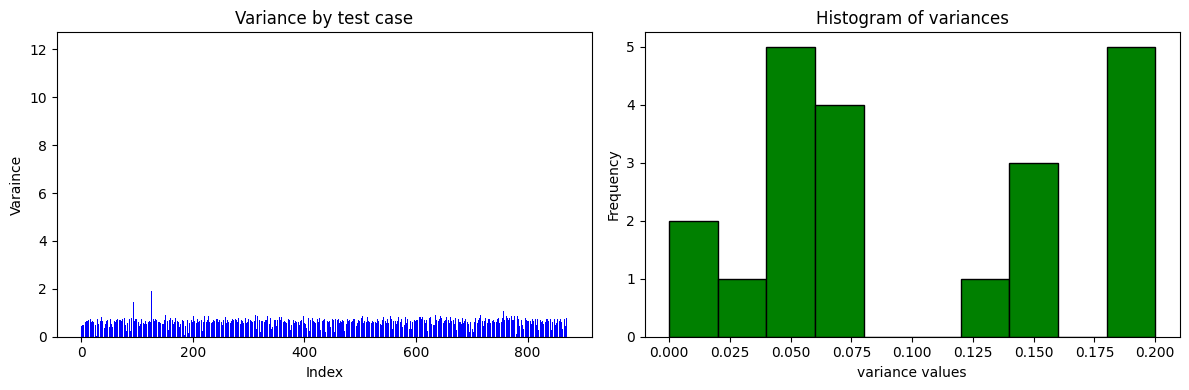

time: 1.7 s (started: 2023-12-14 21:36:54 +00:00)


In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Varaince')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()

In [33]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

time: 795 µs (started: 2023-12-14 21:37:02 +00:00)


In [ ]:
from sklearn.preprocessing import OneHotEncoder


def return_transformed_df(df, vectorizer = CountVectorizer(), test=False):
#     category_dummies = pd.get_dummies(df['Category'])
    df_dummy = clear_data.copy()
    
    
    ohe = OneHotEncoder(sparse_output=False)  
    category_ohe = ohe.fit_transform(df_dummy[['Category']])
    category_cols = ohe.get_feature_names_out(['Category'])
    category_df = pd.DataFrame(category_ohe, columns=category_cols)
#     category_df = category_df.reset_index(drop=True)  
#     df = df.reset_index(drop=True)
#     print(df)
    df = df.join(category_df, how='left')
#     print(category_df)

    
    
#     print(df)
    # scaler = MinMaxScaler()
    # df['Selling Price'] = scaler.fit_transform(df[['Selling Price']])

    df['Product Name'] = df['Product Name'].str.lower() # convert to lowercase
    df['Product Name'] = df['Product Name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    df['Product Name'] = df['Product Name'].str.replace('[^a-z]', ' ') 
    
    ohe = OneHotEncoder(sparse_output=False)  
    name_ohe = ohe.fit_transform(df_dummy[['Product Name']])
    name_cols = ohe.get_feature_names_out(['Product Name'])

    name_df = pd.DataFrame(name_ohe, columns=name_cols)
    
    df = df.join(name_df, how='left')

# #     vectorizer = CountVectorizer()
#     if test:
#         name_tokens_matrix = vectorizer.transform(df['Product Name'])
#     else:
#         name_tokens_matrix = vectorizer.fit_transform(df['Product Name'])
        
#     name_dummies = pd.DataFrame(name_tokens_matrix.toarray(), columns=vectorizer.get_feature_names_out())

#     result_df = pd.concat([df, name_dummies], axis=1) 
    


    X = df.drop(['Category', 'Selling Price', 'Product Name', 'ID'], axis=1)  
    y = df['Selling Price'] 
    return X,y, vectorizer

In [67]:
stop_words = ['for', 'and', 'is', 'a', 'an', 'the']
# cum_jac = 0
# counter = 0
# top_sim = 0
# len_top10 = 0
variance_list = []
for idx in tqdm(range(val_data.shape[0])):
    num = val_data["ID"].iloc[idx]
    pname_ids = hashtable1.lookup(pname_ngrams_list[num])
    
    train_text = train_data[train_data['ID'].isin(pname_ids)]
    val_text = val_data[val_data['ID'].isin([num])]
    X_train, y_train, vectorizer = return_transformed_df(train_text)
    X_test, y_test, _ = return_transformed_df(val_text, vectorizer, test=True)
#     print(pname_ids)
#     print(train_text)
    
#     break
    knn = KNeighborsRegressor(n_neighbors=3)
    if len(pname_ids)>0:
        knn.fit(X_train, y_train) 

        y_pred = knn.predict(X_test.iloc[[0]])

        variance_list.append(abs((y_pred[0] - y_test.iloc[0])/y_test.iloc[0]))
    

print("mean variance:",np.mean(variance_list))
print("median variance", np.median(variance_list))

100%|██████████| 872/872 [08:25<00:00,  1.73it/s]

mean variance: 1.3147199899559947
median variance 0.49833266639989326
time: 8min 25s (started: 2023-12-14 22:24:29 +00:00)


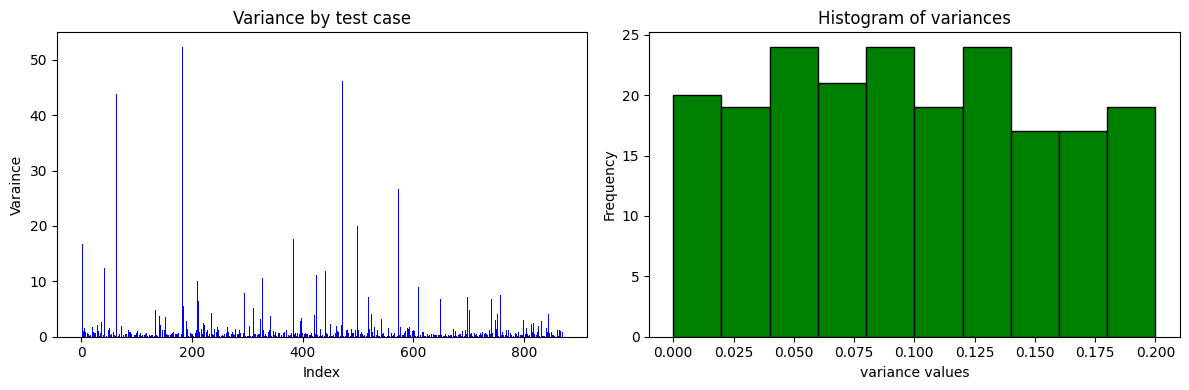

time: 1.76 s (started: 2023-12-14 22:39:28 +00:00)


In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(len(variance_list)), variance_list, color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Varaince')
ax1.set_title('Variance by test case')

ax2.hist(variance_list, bins=10,range=(0, 0.2), color='green', edgecolor='black')
ax2.set_xlabel('variance values')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of variances')

plt.tight_layout()
plt.show()

In [55]:
clear_data

,Product Name,Category,Selling Price
ID,,,
0,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Sports & Outdoors | Outdoor Recreation | Skate...,237.68
1,"Electronic Snap Circuits Mini Kits Classpack, ...",Toys & Games | Learning & Education | Science ...,99.95
2,3Doodler Create Flexy 3D Printing Filament Ref...,Toys & Games | Arts & Crafts | Craft Kits,34.99
3,Guillow Airplane Design Studio with Travel Cas...,Toys & Games | Hobbies | Models & Model Kits |...,28.91
4,Woodstock- Collage 500 pc Puzzle,Toys & Games | Puzzles | Jigsaw Puzzles,17.49
...,...,...,...
8711,Remedia Publications REM536B Money Activity Bo...,Toys & Games | Learning & Education | Counting...,9.31
8712,Trends International NFL La Chargers HG - Mobi...,Toys & Games | Arts & Crafts,6.99
8713,NewPath Learning 10 Piece Science Owls and Owl...,Office Products | Office & School Supplies | E...,37.95


time: 13.8 ms (started: 2023-12-14 17:58:50 +00:00)


In [109]:
val_data

,ID,Product Name,Category,Selling Price
3263,3263,Flash Furniture 24'' Round Blue Metal Indoor-O...,Home & Kitchen | Furniture | Kids' Furniture |...,69.41
1862,1862,"Flyos Games Kiwetin, Various",Toys & Games | Games & Accessories | Card Game...,24.99
7812,7812,The Young Scientists Club Science Art Fusion R...,Toys & Games | Learning & Education | Science ...,16.71
3078,3078,Sidewinder AC/DC Electric Air Pump,Home & Kitchen | Bedding | Air Mattresses & Ac...,24.50
2794,2794,Bright Starts Pretty in Pink Carry Teethe Purse,"Baby Products | Baby Care | Pacifiers, Teether...",3.99
...,...,...,...,...
3795,3795,Walthers Scenemaster HO Scale Model of TransAm...,Toys & Games | Hobbies | Trains & Accessories ...,10.34
5184,5184,Pikmi Pops Jelly Dreams - Hushy The Bear - Col...,Toys & Games | Stuffed Animals & Plush Toys | ...,17.18
2602,2602,Green Toys Dump Truck Puzzle (4 Piece),Toys & Games | Puzzles | Jigsaw Puzzles,10.31
2726,2726,Btswim NFL Pool Noodles (Pack of 3),Toys & Games | Sports & Outdoor Play | Pools &...,10.60


time: 11.5 ms (started: 2023-12-14 14:13:43 +00:00)
